# 3 Feature Encoding

In this chapter we load the data, experiment with different model architectures and finally train the autoencoder model. 

### Imports:

In [1]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Flatten, Reshape, UpSampling2D, Dense, Conv1D, Conv2D, MaxPooling2D, GlobalMaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import visualkeras

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Load the Data:

In [3]:
x_train = pickle.load(open( "./data/x_train.p", "rb" ))
y_train = pickle.load(open( "./data/y_train.p", "rb" ))
x_test  = pickle.load(open( "./data/x_test.p",  "rb" ))
y_test  = pickle.load(open( "./data/y_test.p",  "rb" ))

## 3.2 Building the Autoencoder

In this chapter we load the data, experiment with different model architectures and finally train the autoencoder model. In this section we experimented with different model architectures.

### Try Simple Model Architecture using Dense Layers

We started with a rather simple model architecture. Only two dense layers were used for the encoder and decoder. The latent space consists of 10 neurons, which in the end will allow the extraction of 10 features.

#### Preprocessing:

The interconnected lists containing the pixels of an image (image -> pixel row -> RGB pixel values) are transferred into a long flat list so that they can be used as input for a Dense Layer.

In [4]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
print("Values describing one Image:" , x_train_flat.shape[1])

Values describing one Image: 3072


#### Define Model

Defining the model architecture (Encoder + Decoder -> Autoencoder):

In [6]:
##############################
# two dense layers
##############################

# This is the size of our encoded representations
encoding_dim = 10  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(3072,))

# "encoded" is the encoded representation of the input
x = layers.Dense(64, activation='relu', name='encoder_dense_1')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu', name='encoder_dense_2')(x)

# "decoded" is the lossy reconstruction of the input
x = layers.Dense(64, activation='relu', name='decoder_dense_1')(encoded)
decoded = layers.Dense(3072, activation='sigmoid', name='decoder_dense_2')(x)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Model Architecture Overview:

In [7]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 64)                196672    
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 10)                650       
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 64)                704       
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 3072)              199680    
Total params: 397,706
Trainable params: 397,706
Non-trainable params: 0
_________________________________________________________________


Encoder Model Definition:

In [8]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

Decoder Model Definition:

In [9]:
# This is our encoded (10-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_model = encoded_input

# Retrieve the last layer of the autoencoder model
for layer in autoencoder.layers[3:5]:
    decoder_model = layer(decoder_model)

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_model)

#### Train Model

Autoencoder is compiled before training. In this case we are using the adam optimizer and "mse" as loss function. We noticed that the "mean squared error" could be used as well. In the following term $N$ represents the number of values in the output layer. In this case each RGB component of every pixel of an image: $32*32*3 = 3072$. The true value is represented as $y_i'$. The "binary crossentropy" is defined as:

$$Loss = - \frac{1}{N} \sum_{i} ({y_i' \log(y_i) + (1-y_i') \log (1-y_i)})$$

Using the "binary crossentropy" loss function it is necessary that the output values are between 0 and 1. Therefore we used the sigmoid activation function:

$$ f(x) = \frac{\mathrm{1} }{\mathrm{1} + e^{-x} }  $$ 

In [10]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Define callbacks to evaluate model using tensorboard later:

In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Training:

In [12]:
history = autoencoder.fit(x_train_flat, x_train_flat,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                callbacks=[tensorboard_callback]
               )

Epoch 1/10
157/157 [==============================] - 20s 39ms/step - loss: 0.6799 - accuracy: 0.0010 - val_loss: 0.6501 - val_accuracy: 0.0016
Epoch 2/10
157/157 [==============================] - 5s 33ms/step - loss: 0.6455 - accuracy: 0.0022 - val_loss: 0.6356 - val_accuracy: 0.0012
Epoch 3/10
157/157 [==============================] - 5s 32ms/step - loss: 0.6334 - accuracy: 0.0018 - val_loss: 0.6289 - val_accuracy: 0.0011
Epoch 4/10
157/157 [==============================] - 5s 34ms/step - loss: 0.6281 - accuracy: 0.0021 - val_loss: 0.6272 - val_accuracy: 0.0017
Epoch 5/10
157/157 [==============================] - 5s 34ms/step - loss: 0.6265 - accuracy: 0.0019 - val_loss: 0.6273 - val_accuracy: 0.0037
Epoch 6/10
157/157 [==============================] - 5s 33ms/step - loss: 0.6269 - accuracy: 0.0031 - val_loss: 0.6268 - val_accuracy: 0.0032
Epoch 7/10
157/157 [==============================] - 5s 33ms/step - loss: 0.6263 - accuracy: 0.0024 - val_loss: 0.6268 - val_accuracy: 0.004

#### Evaluate Model

After ten epochs it seems like the loss will not decrease significantly anymore. With this initial model we reached a validation loss of 0.6173.

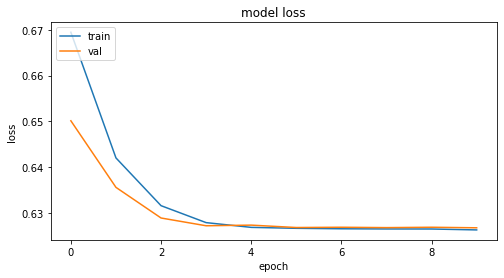

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Encode Images:

In [14]:
encoded_images = encoder.predict(x_test_flat)

Display latent Space predicted by the encoder for the first image in the test dataset:

In [15]:
print("Extracted Features of a single Image:\n\n", encoded_images[0]) 

Extracted Features of a single Image:

 [ 0.         0.         7.726702   0.         0.         0.
  0.         0.        11.70938    4.9143286]


Decoded Images:

In [16]:
decoded_images = decoder.predict(encoded_images)

Display latent Space predicted by the encoder for the first image in the test dataset:Next, we visualized the images after encoding and decoding and compared them to the original image. As expected, the many characteristics were lost. On the other hand, especially considering that these reproductions are only based on 10 features it seems evident that some features are captured successfully by the model. Examples of decoded Pictures:

In [17]:
# definition to show original image and reconstructed image
def showDecodedImages(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

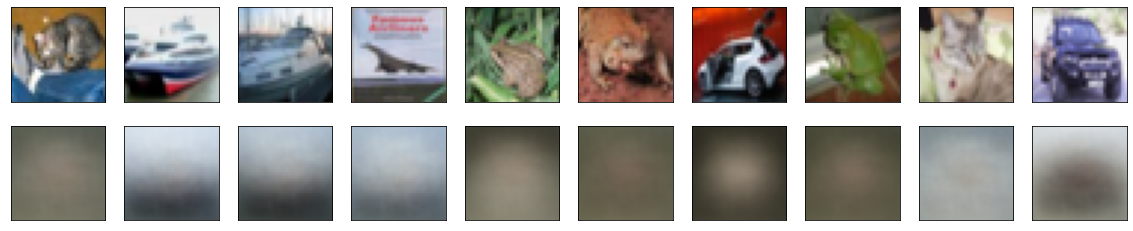

In [18]:
showDecodedImages(x_test, decoded_images)

### Try Convoluational Model Architecture

Display latent Space predicted by the encoder for the first image in the test dataset:Next we experimented building an autoencoder using convolutional layer. 

**Convolutional Layer:**

Convolutional layer are using kernels to extract features from an image. These kernels are learned during training. Specified must be the kernel size (3x3 in our case) and the number of features to extract (64 in the first convolutional layer):

![Convolutional Layer](./figures/convolution.png)

*(Part of the illustration was created by user vdumoulin on github.com)*

We did use the "same" padding strategy. Otherwise, the resulting image would be smaller than the original. This is because on the edges the filter cannot be applied without padding. To avoid this problem values can be added at the edges of the original matrix (e.g., zeros) such that the resulting matrix is the same size than the original one.

**Max Pooling Layer:** 

The actual reduction of the image is done using this layer. Output values of the convolutional layer in a given window size (2x2 in this case) are reduced to a single value by only keeping the maximum value in this window.

**Upsampling Layer:** 

This layer can be seen as a counter part to the max pooling layer. While the max pooling layer reduces the size of the image (or more general: the matrix) this layer increases the dimensions of the input. Here it is used to transform the latent space back up to the dimensions of the original image. Also, interpolation, hence averaging, for achieving smoothness is applied.

![Upscaling Layer](./figures/upscaling.png)

*(Part of the illustration was taken from https://www.machinecurve.com/index.php/2019/12/11/upsampling2d-how-to-use-upsampling-with-keras/)*


**Batch Normalization Layer:** 

Batch Normalization a technique that is used to whiten activation distributions by controlling the mean and standard deviation of layer outputs. This is done for a batch of examples.

**Flatten and Reshape Layer:** 

These layers really do just transform the output from the previous layers into a different shape. The flatten layer is used in the encoder to transform the three-dimensional output after the convolution into a simple list such that they can be parsed along to a dense layer. The reshape layer is used in the decoder to reverse this effect such that the whole model does predict an image.   


#### Define Model

##### Build model with convolution layer and vector latent space (256  neurons)

In [19]:
##############################
# Encoder
##############################

input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)

##############################
# Decoder
##############################

x = Reshape((4, 4, 16))(encoded)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

# This model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

##### Build model with convolution layer and vector latent space (10 neurons)

In [20]:
##############################
# Encoder
##############################

input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
# with dense from 256 to 10
encoded = Dense(10, activation='sigmoid')(x)

##############################
# Decodr
##############################

# with dense from 10 to 256
x = Dense(256, activation='relu')(encoded)
x = Reshape((4, 4, 16))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [21]:
autoencoder = Model(input_img, decoded)

**Visualization of the Model Architecture:**

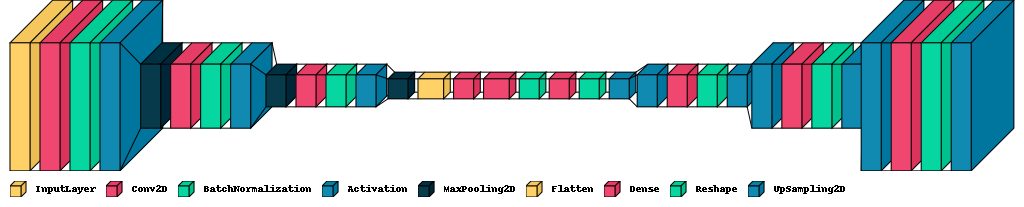

In [22]:
#https://github.com/paulgavrikov/visualkeras/
visualkeras.layered_view(autoencoder, legend=True)

In [23]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 32)        128 

In [24]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

#### Train Model

In [25]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Define callbacks to evaluate model using tensorboard later:

In [26]:
log_dir = "logs/fit_conv/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Training:

In [27]:
history = autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                callbacks=[tensorboard_callback]
               )

Epoch 1/5
1250/1250 [==============================] - 221s 170ms/step - loss: 0.0336 - accuracy: 0.4338 - val_loss: 0.0243 - val_accuracy: 0.5117
Epoch 2/5
1250/1250 [==============================] - 174s 139ms/step - loss: 0.0237 - accuracy: 0.5277 - val_loss: 0.0222 - val_accuracy: 0.5722
Epoch 3/5
1250/1250 [==============================] - 168s 134ms/step - loss: 0.0227 - accuracy: 0.5880 - val_loss: 0.0217 - val_accuracy: 0.6056
Epoch 4/5
1250/1250 [==============================] - 260s 208ms/step - loss: 0.0223 - accuracy: 0.5933 - val_loss: 0.0221 - val_accuracy: 0.5867
Epoch 5/5
1250/1250 [==============================] - 214s 171ms/step - loss: 0.0222 - accuracy: 0.5921 - val_loss: 0.0216 - val_accuracy: 0.5988


#### Evaluate Model

With this improved model we reached a validation loss of 0.6053 compared to 0.6173 with the simpler model.

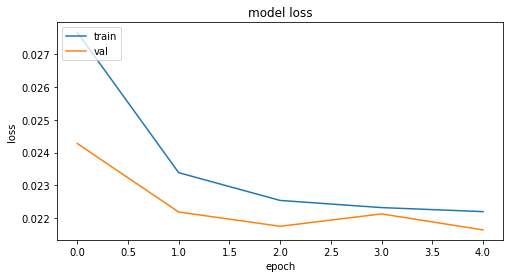

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()